### 4.1 Define class DQN 

In [1]:
import numpy as np

############################

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

############################

# DQN
class DQN:
        def __init__(
          self,
          actions_num,
          state_size,
          learning_rate = 0.001,
          gamma = 0.99,
          epsilon_min = 0.05,
          epsilon_start = 0.9,
          replace_target_iter = 300,
          memory_size = 500,
          batch_size = 2,
          epsilon_increment = None,
        ):
        self.actions_num = actions_num
        self.state_size = state_size
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = epsilon_increment
        self.epsilon = epsilon_start if epsilon_increment is not None else self.epsilon_min
        self.save_model_path = './weights/DQN_model.ckpt'
        self.memory_counter = 0

        # learned steps counter
        self.steps_counter = 0

        # initialize memory [s, a, r, s_, done]
        self.memory = np.zeros((self.memory_size, state_size * 2 + 3))

        # build target_net and q_net
        self.build_net()
        t_params = tf.get_collection('target_net_params')
        q_params = tf.get_collection('q_net_params')
        self.replace_target = [tf.assign(t, q) for t, q in zip(t_params, q_params)]

        # gpu setting
        config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.6
        self.sess = tf.Session(config=config)

        self.sess.run(tf.global_variables_initializer())

        def build_net(self):
            # build q_net
            self.state = tf.placeholder(tf.float32, [None, self.state_size], name='state')
            self.q_target = tf.placeholder(tf.float32, [None, self.actions_num], name='Q_target')
            with tf.variable_scope('q_net'):
                # c_names(collections_names) are the collections to store variables
                  c_names, neurons_layer_1, w_initializer, b_initializer = \
                  ['q_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 100, \
                  tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

                # layer 1
                with tf.variable_scope('layer_1'):
                    w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
                    b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
                    layer_1 = tf.nn.relu(tf.matmul(self.state, w_layer_1) + b_layer_1)

                # layer 2
                with tf.variable_scope('layer_2'):
                    w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
                    b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
                    self.q_value = tf.matmul(layer_1, w_layer_2) + b_layer_2

            with tf.variable_scope('loss'):
                self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_value))
            with tf.variable_scope('train'):
                self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

            # build target_net
            self.state_t = tf.placeholder(tf.float32, [None, self.state_size], name='state_t')    # input
            with tf.variable_scope('target_net'):
                # c_names(collections_names) are the collections to store variables
                c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

                # layer 1
                with tf.variable_scope('layer_1'):
                    w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
                    b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
                    layer_1 = tf.nn.relu(tf.matmul(self.state_t, w_layer_1) + b_layer_1)

                # layer 2


                # Note that q_next (Q(s’, a’)) is the q value given by the target network while R + Q(s’, a’) is the q_target. 
                with tf.variable_scope('layer_2'):
                    w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
                    b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
                    self.q_next = tf.matmul(layer_1, w_layer_2) + b_layer_2

      
    def store_transition(self, s, a, r, s_, done):
        s=s.reshape(-1)
        s_=s_.reshape(-1)
        transition = np.hstack((s, [a, r], s_, done))

        # replace the old memory with new observations
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when fed into tf placeholder
        observation = observation[np.newaxis, :]
        # epsilon-greedy
        if np.random.uniform() > self.epsilon:
            action_values = self.sess.run(self.q_value, feed_dict={self.state: observation})
            action = np.argmax(action_values)
        else:
            action = np.random.randint(0, self.actions_num)
        return action

    def learn(self):
        # replace target parameters every once a while
        if self.steps_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target)

        # sample a batch from the memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_value = self.sess.run(
          [self.q_next, self.q_value],
          feed_dict={
            self.state_t: batch_memory[:, -self.state_size-1:-1],  # fixed params # s_
            self.state: batch_memory[:, :self.state_size],  # newest params # s
          })

        # calculate q_target
        q_target = q_value.copy()

        # only change the action-values of this batch, because we only calculate loss on the batch observations
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        act_index = batch_memory[:, self.state_size].astype(int)
        reward = batch_memory[:, self.state_size + 1]
        done = batch_memory[:, -1] 
        ############################
        for batch_idx in batch_index:
          # memory -> s,a,r,s_,done
            A = act_index[batch_idx]
            R = reward[batch_idx]
            Done = done[batch_idx]
            if Done:
                q_target[batch_idx,A] = R
            else:
                q_target[batch_idx,A] = R + self.gamma*np.max(q_next[batch_idx])


        # train q_net
        _, self.cost = self.sess.run([self._train_op, self.loss],
                        feed_dict= {self.state: batch_memory[:, :self.state_size],
                              self.q_target: q_target}
                        )
        # change epsilon
        self.epsilon = self.epsilon - self.epsilon_increment if self.epsilon > self.epsilon_min else self.epsilon_min
        self.steps_counter += 1

    def store(self):
        saver = tf.train.Saver() 
        saver.save(self.sess, self.save_model_path)
  
    def restore(self):
        saver = tf.train.Saver() 
        saver.restore(self.sess, self.save_model_path)






1.15.0


### 4.2 Environment setting

In [2]:
import gym
# cart pole gym environment
env = gym.make("CartPole-v0")
env._max_episode_steps = 500
# state and action space
print(env.action_space)
print(env.observation_space)
# observation
env.reset()
# state, reward, done, info
print(env.step(1))

Discrete(2)
Box(4,)
(array([ 0.03467452,  0.15515745, -0.0216516 , -0.34774936]), 1.0, False, {})


### 4.3 Play and Train the network

In [ ]:
# play the game and train the network
np.set_printoptions(threshold=np.inf)
episode_length_set = []
tf.reset_default_graph()
total_time_steps = 100000

RL = DQN(actions_num = 2, gamma = 0.99,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0.01,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = 0.00001,)

new_state = env.reset()
done = False
episode_length_counter = 0
#print('1',new_state) #for test
for step in range(total_time_steps):
  # calculate episode length, calculate and take action, observe and store transition into memory.
    S = new_state
    A = RL.choose_action(S)
    S_, R, done, info = env.step(A)
    RL.store_transition(S,A,R,S_,done)
    if done:
        new_state = env.reset()
        episode_length_set.append(episode_length_counter+1)
        episode_length_counter = 0
    else:
        new_state = S_ 
  
    if step > 200:
        RL.learn()
   # break # for test
    episode_length_counter += 1
    if episode_length_counter == 500:
        RL.store()
RL.store()

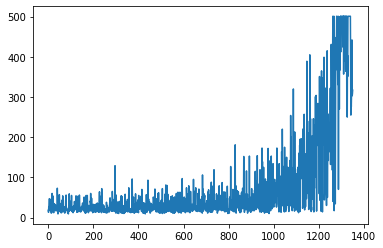

In [4]:
from matplotlib import pyplot as plt
plt.plot(episode_length_set)

### 4.4 Test

In [5]:
# test our network
tf.reset_default_graph()
RL = DQN(actions_num = 2, gamma = 1,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = None,)
# load saved parameters
RL.restore()
# run 100 trails and print how long can the agent hold the cart pole for each trail
for i in range(100):
    new_state = env.reset()
    done = False
    episode_length_counter = 0
    while (not done):
        S = new_state
        A = RL.choose_action(S)
        S_, R, done, info = env.step(A)
    #RL.store_transition(S,A,R,S_,done)
        episode_length_counter += 1
        new_state = S_ 
    print('During the trail ', i+1, ' , the agent played ', episode_length_counter, 'unit time')
  

INFO:tensorflow:Restoring parameters from ./weights/DQN_model.ckpt
During the trail  1  , the agent played  386 unit time
During the trail  2  , the agent played  377 unit time
During the trail  3  , the agent played  436 unit time
During the trail  4  , the agent played  397 unit time
During the trail  5  , the agent played  380 unit time
During the trail  6  , the agent played  436 unit time
During the trail  7  , the agent played  405 unit time
During the trail  8  , the agent played  403 unit time
During the trail  9  , the agent played  341 unit time
During the trail  10  , the agent played  371 unit time
During the trail  11  , the agent played  434 unit time
During the trail  12  , the agent played  363 unit time
During the trail  13  , the agent played  324 unit time
During the trail  14  , the agent played  435 unit time
During the trail  15  , the agent played  357 unit time
During the trail  16  , the agent played  411 unit time
During the trail  17  , the agent played  392 